In [2]:
# %load_ext autoreload
# %autoreload 2

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import pickle
import datetime
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0,os.path.dirname(os.path.dirname(currentdir)))

from mlopt.ACO import ACO
from mlopt.AGMLP_Residual import AGMLP_Residual
from mlopt.AGMLP_VR_Residual import AGMLP_VR_Residual
from mlopt.AGEnsemble_Residual import AGEnsemble_Residual
from mlopt.TimeSeriesUtils import *
from correctData import *
import copy

warnings.filterwarnings("ignore")

# Load and Process Data

In [3]:
inmet_csv = './historical_data_BOMJESUSDALAPA.csv'
save_scaler = "florianopolis_MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 15*24

posicao_final=len(df_inmet)
posicao_inicial=posicao_final - ultimos_dias

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps', 'vento_rajada_max_mps']].iloc[posicao_inicial:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[posicao_inicial:].values.reshape(-1,1)

print(df_inmet.iloc[posicao_inicial,:].data, df_inmet.iloc[posicao_inicial,:].hora,
      df_inmet.iloc[posicao_final-1,:].data,df_inmet.iloc[posicao_final-1,:].hora)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
pickle.dump(MaxAbsScaler_gen, open('resultados/MaxAbsScaler_gen.pckl', 'wb'))

object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
int64
data                           object
hora                            int64
preciptacao_total_mm          float64
pressao_atm_mB                float64
pressao_atm_max_mB            float64
pressao_atm_min_mB            float64
radiacao_global_wpm2          float64
temp_ar_bulbo_seco_c          float64
temp_ponto_orvalho_c          float64
temp_max_c                    float64
temp_min_c                    float64
temp_orvalho_max_c            float64
temp_orvalor_min_c            float64
umidade_relativa_max_prcnt    float64
umidade_relativa_min_prcnt    float64
umidade_relativa_prcnt        float64
vento_dir_gr                  float64
vento_rajada_max_mps          float64
vento_velocidade_mps          float64
ano                           float64
mes                           float64
dia                           float64
dtype: object
2020/07/17 0 2020/07/31 23


# SARIMAX 

## Auto ARIMA

In [5]:
pm.auto_arima(y=gen, X=exog, seasonal=True, m=24, maxiter=50, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-92.428, Time=0.50 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-807.455, Time=3.87 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-545.838, Time=4.34 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-60.479, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-650.212, Time=0.43 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=15.80 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.20 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-737.426, Time=3.36 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=15.27 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-806.461, Time=4.53 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=-805.127, Time=4.65 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=-714.022, Time=3.74 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=-

ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(2, 0, 2, 24),
      suppress_warnings=True, with_intercept=False)

In [6]:
mod = SARIMAX(endog=gen, exog=exog, order=(3, 0, 2), seasonal_order=(2, 0, 2, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_auto = results.predict()
mape_autoarima = MAPE(y_sarimax_auto, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -825.1507882853775, Mape: 0.9518494576816882


## PSO-ACO Parametrization

In [7]:
p = [0, 1, 2, 3, 4]
d = [0, 1]
q = [0, 1, 2, 3]
sp = [0, 1, 2, 3]
sd = [0, 1]
sq = [0, 1, 2, 3]
s = [24, 48] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]

options_PSO = {'n_particles':5,'n_iterations':3,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':3, 'antTours':3, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
exogColumns = ['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt', 'vento_velocidade_mps', 'vento_rajada_max_mps']
y_sarimax_PSO_ACO = sarimax_PSO_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, options_ACO=options_ACO, exogColumns=exogColumns, verbose=False)
                                   
mape_pso_aco = MAPE(y_sarimax_PSO_ACO, gen)
print("Mape: {0}".format(mape_pso_aco))

2021-02-09 23:08:28,838 - root - INFO - Original search Space: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-02-09 23:08:28,838: INFO - Original search Space: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-02-09 23:08:28,841 - root - INFO - search Space with Exog Possibilities: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-02-09 23:08:28,841: INFO - search Space with Exog Possibilities: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-02-09 23:08:28,843 - root - INFO - PSO boundaries: [0. 0. 0. 0. 0.] [3, 1, 3, 2, 31]
2021-02-09 23:08:28,843: INFO - PSO boundaries: [0. 0. 0. 0. 0.] [3, 1, 3, 2, 31]
2021-02-09 23:08:28,845 - root - INFO - 5
2021-02-09 23:08:28,845: INFO - 5
2021-02-09 23:08:29,424 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 

In [10]:
mod = SARIMAX(endog=gen, exog=exog[:,[1,2,3]], order=(1,0,0), seasonal_order=(2,0,2,24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_PSO_ACO_hand = results.predict()
mape_pso_aco_hand = MAPE(y_sarimax_PSO_ACO_hand, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_pso_aco_hand))

AICc: -831.8021789080478, Mape: 0.9233119200458031


## DUMP Sarimax

In [11]:
y_sarimax = y_sarimax_PSO_ACO_hand
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('resultados/dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

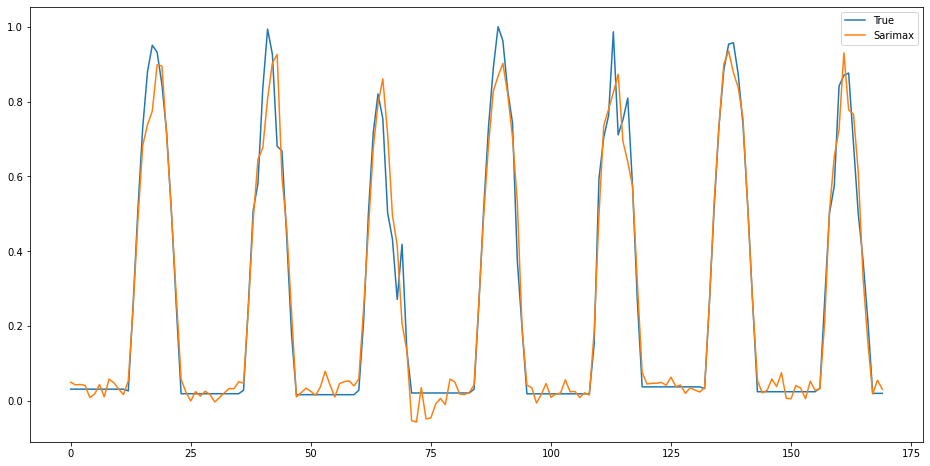

In [3]:
dict_gen_ysarimax = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

## Train

In [22]:
# ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 4, size_pop = 15, prob_mut=0.8,
#                                  tr_ts_percents=tr_ts_percents).search_best_model()
# best_mlp_residual = ag_mlp_residual._best_of_all
# pickle.dump(best_mlp_residual, open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'wb'))

| 3/4 [00:22<00:07,  7.59s/it]
100%|██████████| 4/4 [00:27<00:00,  6.96s/it]

100%|██████████| 4/4 [00:19<00:00,  4.99s/it]

100%|██████████| 4/4 [01:19<00:00, 19.81s/it]

100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

100%|██████████| 4/4 [00:22<00:00,  5.61s/it]

100%|██████████| 4/4 [00:06<00:00,  1.50s/it]

100%|██████████| 4/4 [00:47<00:00, 12.00s/it]

100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

100%|██████████| 4/4 [00:53<00:00, 13.38s/it]

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

100%|██████████| 4/4 [00:22<00:00,  5.69s/it]

100%|██████████| 4/4 [00:08<00:00,  2.16s/it]

 25%|██▌       | 1/4 [17:22<52:06, 1042.02s/it]generation: 1

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

100%|██████████| 4/4 [00:13<00:00,  3.28s/it]

100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

100%|██████████| 4/4 [00:47<00:00, 11.98s/it]

100%|██████████| 4/4 [00:13<00:00,  3.47s/it]

100%|██████████| 4/4 [00:16<00:00,  4.14s/it]

100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

100%|█████████

## Análise Resultados

[7, 15, 12, 8, MLPRegressor(activation='tanh', early_stopping=True,
             hidden_layer_sizes=(66, 3, 1), learning_rate='invscaling',
             max_iter=500, solver='lbfgs'), MLPRegressor(early_stopping=True, hidden_layer_sizes=(22, 44, 9), max_iter=500,
             solver='lbfgs'), 0.031054650812002642]
Teste para saber se pegou o melhor mesmo! 0.031054650812002687 == 0.031054650812002642 ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.0311518818849064
MSE:  0.002527930260229751
MAPE:  0.34858466479696903
HIBRIDO
MAE:  0.031054650812002687
MSE:  0.003046259939783726
MAPE:  0.19175864064979325
GANHO MAE:
0.00312119419503909
GANHO MSE:
-0.20504113096334664
GANHO MAPE:
0.44989364130093934


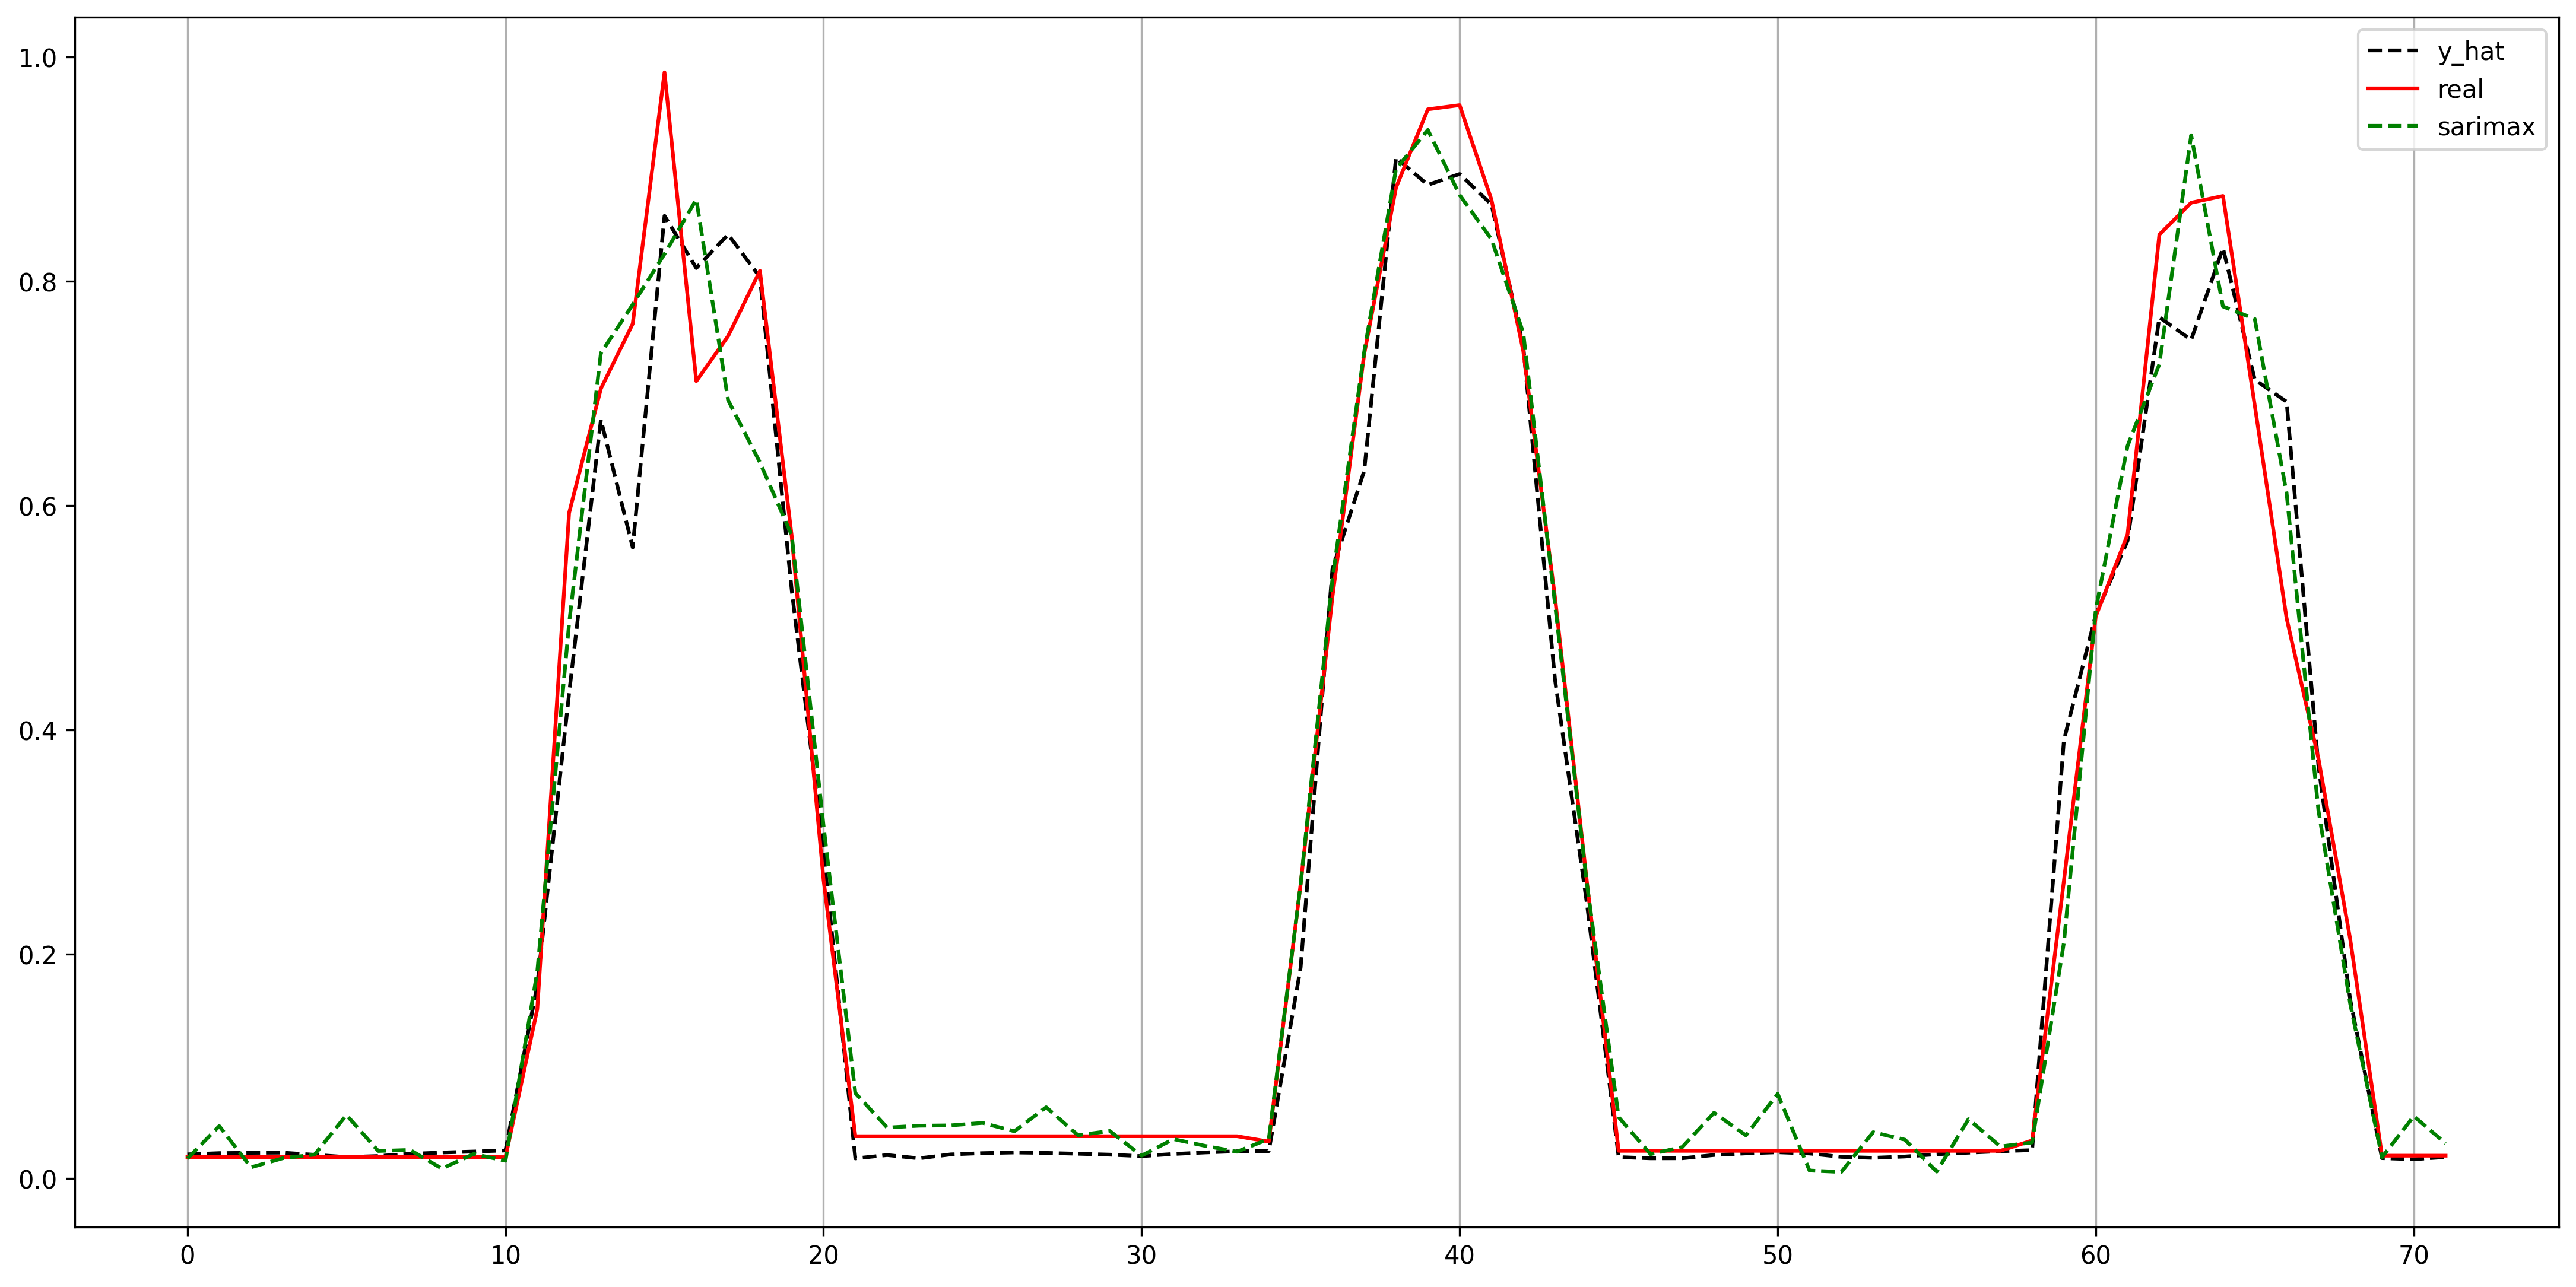

In [4]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best_mlp_residual = pickle.load(open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best_mlp_residual[0],
                                                                                            tr_ts_percents)
erro_estimado = np.concatenate((best_mlp_residual[4].predict(erro_train_entrada),
                                best_mlp_residual[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best_mlp_residual[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best_mlp_residual[2],
                                                                best_mlp_residual[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best_mlp_residual[5].predict(X_in_train), best_mlp_residual[5].predict(X_in_test)])
y_estimado_all_residual = y_estimado_all
y_estimado_so_test = best_mlp_residual[5].predict(X_in_test)

len_dt = len(data_test)

print(best_mlp_residual)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test,
                                                                        data_test),best_mlp_residual[6]))
print (mae(y_estimado_so_test, data_test) ==  best_mlp_residual[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

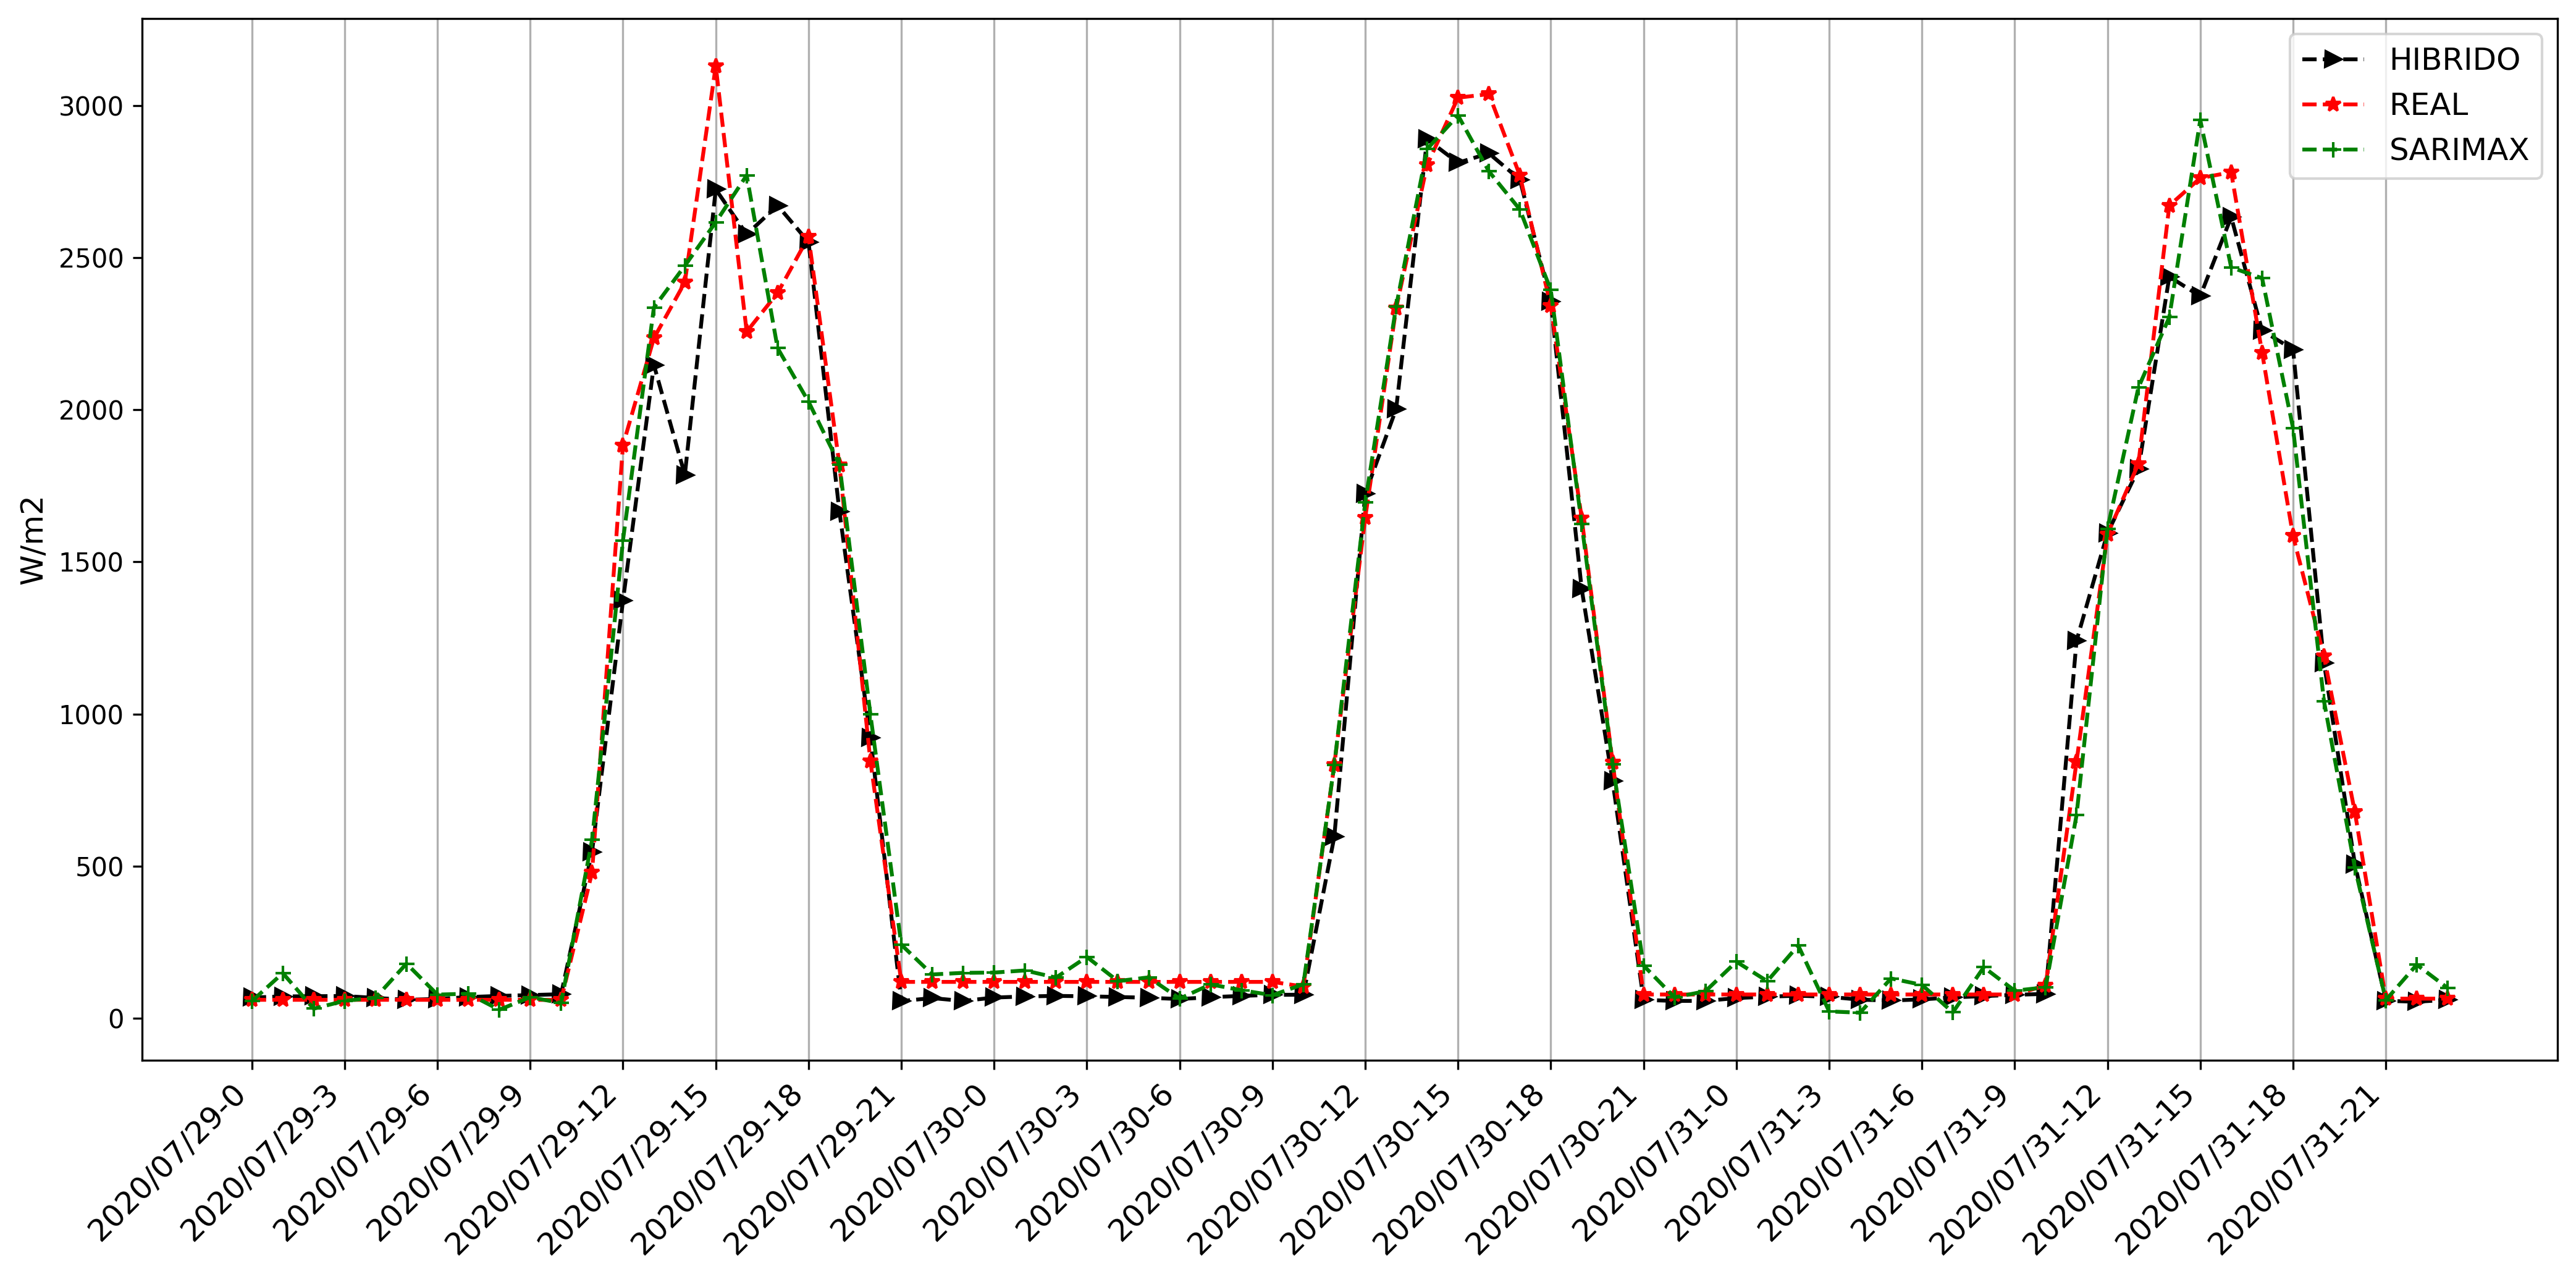

In [10]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpresidual_epoch4_pop15.png', dpi=300)

# Algoritmo AGMLP_VR_Residual

## Train

In [ ]:
tr_ts_percents=[80,20]

In [25]:
# ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 4, size_pop = 15,
#                                        prob_mut=0.2, tr_ts_percents=tr_ts_percents).search_best_model()

# best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

# pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

0/4 [00:00<?, ?it/s]
100%|██████████| 4/4 [00:07<00:00,  1.87s/it]

100%|██████████| 4/4 [00:21<00:00,  5.34s/it]

100%|██████████| 4/4 [00:08<00:00,  2.16s/it]

100%|██████████| 4/4 [00:32<00:00,  8.11s/it]

100%|██████████| 4/4 [00:15<00:00,  3.80s/it]

100%|██████████| 4/4 [00:15<00:00,  3.94s/it]

100%|██████████| 4/4 [00:19<00:00,  4.98s/it]

100%|██████████| 4/4 [00:21<00:00,  5.45s/it]

100%|██████████| 4/4 [00:10<00:00,  2.69s/it]

100%|██████████| 4/4 [00:26<00:00,  6.57s/it]

100%|██████████| 4/4 [00:14<00:00,  3.57s/it]

 25%|██▌       | 1/4 [13:21<40:05, 801.89s/it]generation: 1
start_set_fit: 1

100%|██████████| 4/4 [00:18<00:00,  4.56s/it]

100%|██████████| 4/4 [00:33<00:00,  8.25s/it]

100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

100%|██████████| 4/4 [00:30<00:00,  7.55s/it]

100%|██████████| 4/4 [00:17<00:00,  4.47s/it]

100%|██████████| 4/4 [00:28<00:00,  7.07s/it]

100%|██████████| 4/4 [00:31<00:00,  7.85s/it]

100%|██████████| 4/4 [00:24<00:00,  6.14s/it]

100%|███

## Análise Resultados

[3, 20, 5, 17, 11, <mlopt.AgMlp.AgMlp object at 0x00000214BC58C3D0>, <mlopt.AgMlp.AgMlp object at 0x00000214BC6CF9A0>, 0.032241696989517794]
Teste para saber se pegou o melhor mesmo! 0.032241696989517774 == <mlopt.AgMlp.AgMlp object at 0x00000214BC6CF9A0> ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.0311518818849064
MSE:  0.002527930260229751
MAPE:  0.34858466479696903
HIBRIDO
MAE:  0.032241696989517774
MSE:  0.0027826412054856348
MAPE:  0.25194836125406006
GANHO MAE:
-0.03498392516502857
GANHO MSE:
-0.10075869151261108
GANHO MAPE:
0.277224770054627


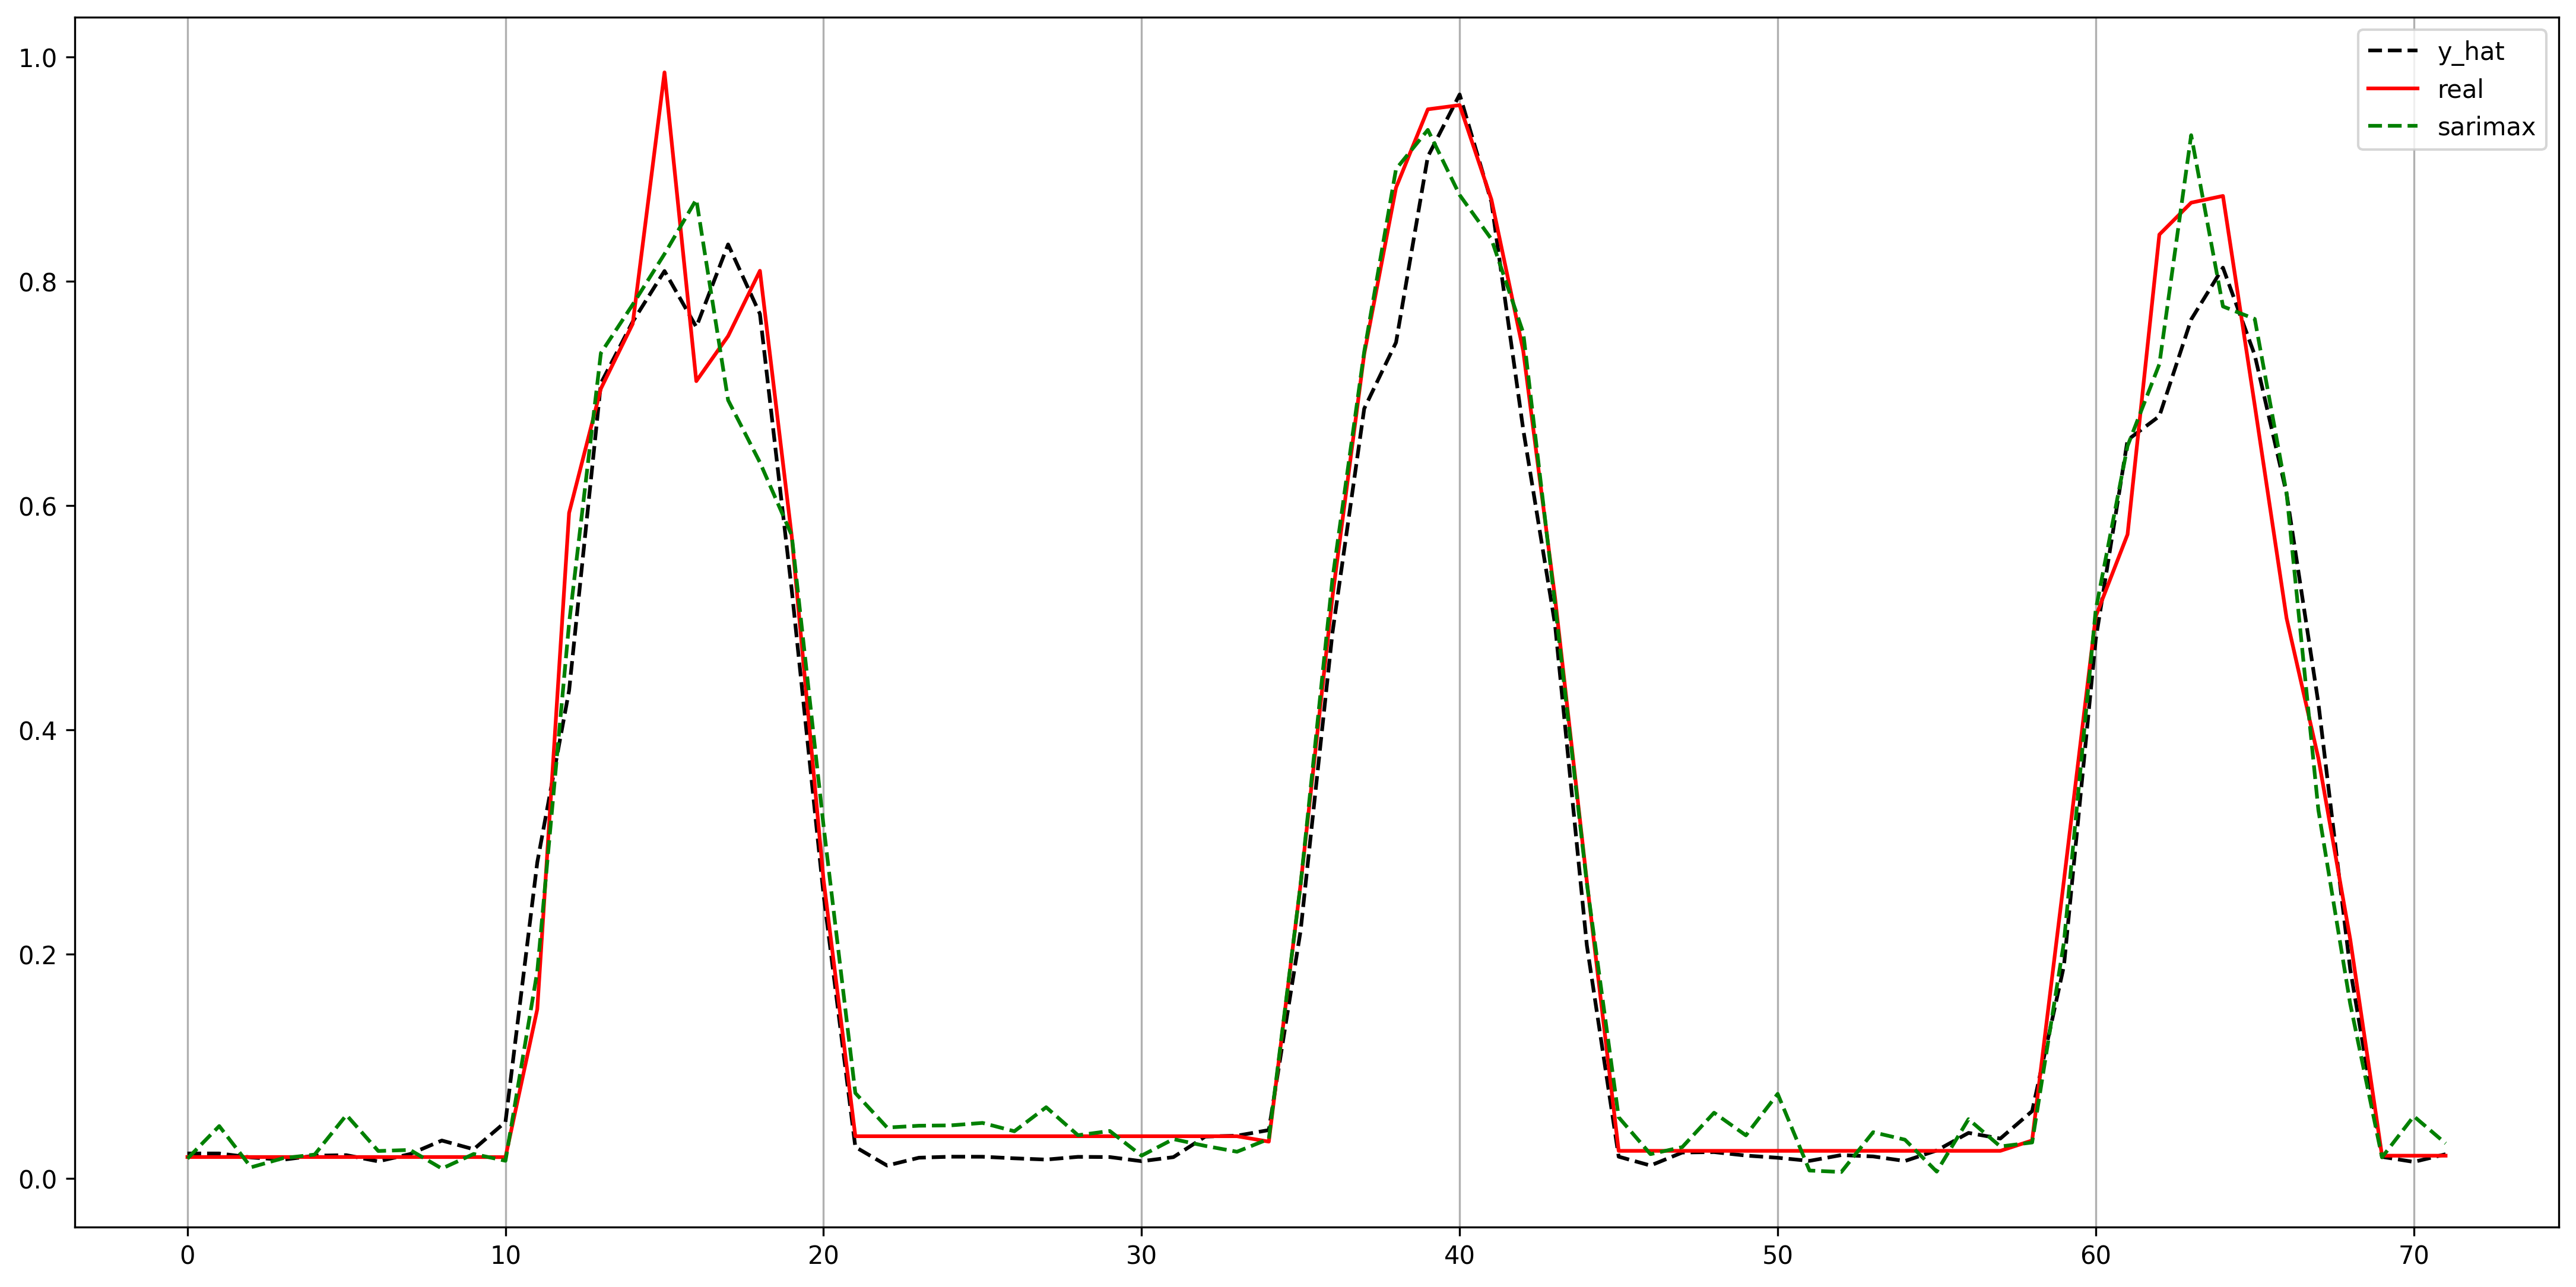

In [5]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_all_vr_residual = y_estimado_all
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

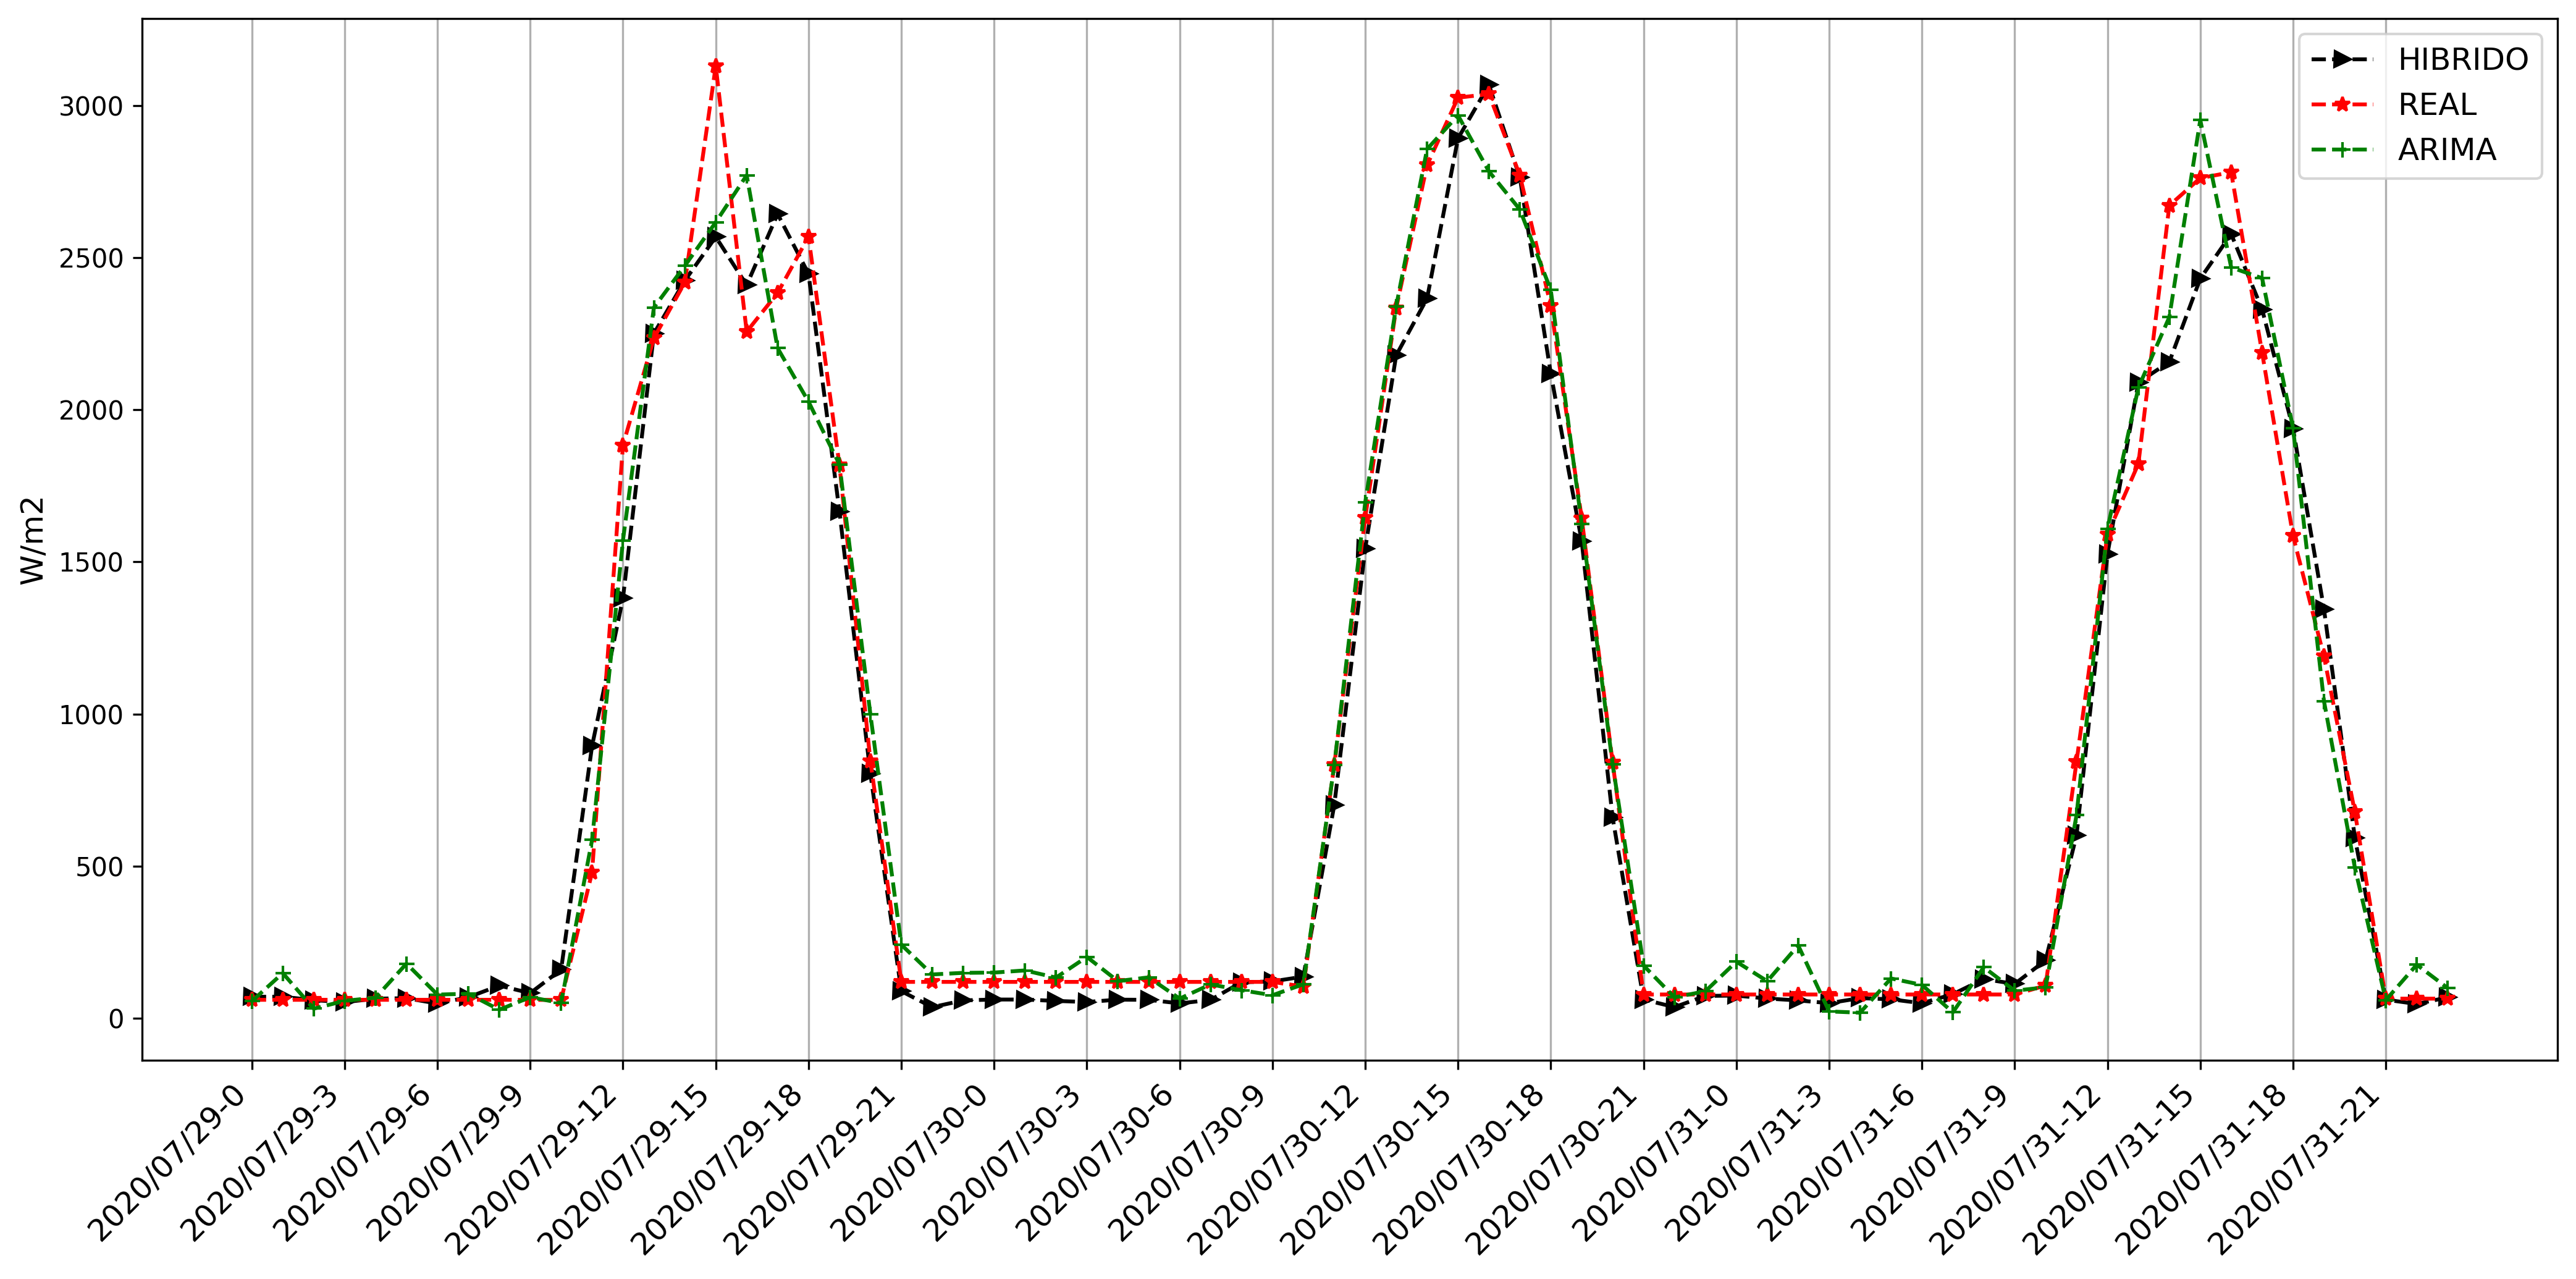

In [13]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/florianopolis_agmlpvrresidual_epoch4_pop15.png', dpi=300)

# LSTM + MLP

Without exogenous variables

https://www.sciencedirect.com/science/article/abs/pii/S0360544218302056

https://www.sciencedirect.com/science/article/abs/pii/S0960148120308557

## Train

In [8]:
from mlopt.ACOLSTM import ACOLSTM
# Importing only here becouse TF takes too long to import

options_ACO={'antNumber':3, 'antTours':2, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
fl_qtn = [10, 30, 70, 100]
fl_func = list(range(6))             
sl_qtn = [5, 10, 20, 40]
sl_func = list(range(6))
tl_qtn = [1, 10, 15]
tl_func = list(range(6))
optimizer = list(range(4))
epochs = list(range(3))
searchSpace = [fl_qtn, fl_func, sl_qtn, sl_func, tl_qtn, tl_func, optimizer, epochs]
X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


In [12]:
lstmOptimizer = ACOLSTM(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm,1,
                        options_ACO=options_ACO)

final_model, y_hat = lstmOptimizer.optimize(searchSpace)

  0%|          | 0/2 [00:00<?, ?it/s]

2021-03-30 00:59:16,953 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 00:59:16,953: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 00:59:17,041 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 00:59:17,041: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:02:35,354 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13FAA550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:02:35,354: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13FAA550> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:02:35,416 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:02:35,416: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:02:35,527 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:02:35,527: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:05:27,865 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C14009940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:05:27,865: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C14009940> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:05:27,913 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:05:27,913: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:05:28,237 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:05:28,237: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:12:00,108 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C8D8B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:12:00,108: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C8D8B0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:12:00,223 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:12:00,223: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:12:00,323 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:12:00,323: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:16:18,400 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C46C3BD30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:16:18,400: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C46C3BD30> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:16:18,489 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:16:18,489: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:16:18,696 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:16:18,696: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:22:42,877 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:22:42,877: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8040> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:22:42,963 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:22:42,963: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:22:43,404 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:22:43,404: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:28:56,615 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8D30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:28:56,615: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8D30> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:28:58,430 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:28:58,430: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:28:58,631 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:28:58,631: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:35:30,347 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C470093A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:35:30,347: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C470093A0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:35:30,425 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:35:30,425: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:35:30,538 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:35:30,538: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:41:31,462 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49FE6670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:41:31,462: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49FE6670> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:41:31,560 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:41:31,560: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:41:31,653 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:41:31,653: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:43:45,477 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:43:45,477: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C430> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:43:45,599 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:43:45,599: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:43:45,687 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:43:45,687: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:45:51,454 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C1F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:45:51,454: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C1F0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:45:51,549 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:45:51,549: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:45:51,652 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:45:51,652: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:47:56,514 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C4440C040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:47:56,514: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C4440C040> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:47:56,619 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:47:56,619: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:47:56,974 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:47:56,974: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:51:32,168 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13F0A4C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:51:32,168: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13F0A4C0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

ACO-All Best Response: [30  2 10  4 10  4  1  2]. Fitness: 0.045856797266949134



2021-03-30 01:51:32,283 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:51:32,283: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:51:32,385 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:51:32,385: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:57:24,542 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C445C6310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:57:24,542: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C445C6310> triggered tf.function retracing. Tracing is expensive and the excessive numbe

In [17]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1640      
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


In [15]:
final_model.save('./resultados/lstm_model')

INFO:tensorflow:Assets written to: ./resultados/lstm_model\assets


2021-03-30 09:17:58,576 - tensorflow - INFO - Assets written to: ./resultados/lstm_model\assets
2021-03-30 09:17:58,576: INFO - Assets written to: ./resultados/lstm_model\assets


## Results

In [6]:
from tensorflow import keras

_, _, X_test_lstm, y_test_lstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)

loadedmodel = keras.models.load_model('./resultados/lstm_model')
y_hat_lstm = loadedmodel.predict(X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('LSTM')
print('MAE: ', mae(y_hat_lstm, y_test_lstm))
print('MSE: ', mse(y_hat_lstm, y_test_lstm))
print('MAPE: ', MAPE(y_hat_lstm, y_test_lstm))

2021-05-28 10:17:16,303 - tensorflow - INFO - Enabling eager execution
2021-05-28 10:17:16,303: INFO - Enabling eager execution
2021-05-28 10:17:16,336 - tensorflow - INFO - Enabling v2 tensorshape
2021-05-28 10:17:16,336: INFO - Enabling v2 tensorshape
2021-05-28 10:17:16,338 - tensorflow - INFO - Enabling resource variables
2021-05-28 10:17:16,338: INFO - Enabling resource variables
2021-05-28 10:17:16,340 - tensorflow - INFO - Enabling tensor equality
2021-05-28 10:17:16,340: INFO - Enabling tensor equality
2021-05-28 10:17:16,342 - tensorflow - INFO - Enabling control flow v2
2021-05-28 10:17:16,342: INFO - Enabling control flow v2


X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


2021-05-28 10:17:16,952 - tensorflow - WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-05-28 10:17:16,952: WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-05-28 10:17:18,157 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:17:18,157: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when runn

Resultado Dados Teste!
LSTM
MAE:  0.0427739069937352
MSE:  0.006897471314709104
MAPE:  0.21161962662854383


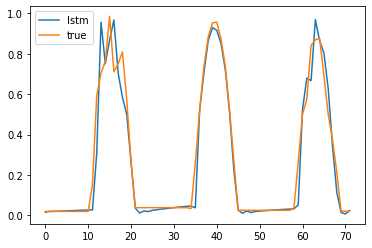

In [11]:
plt.plot(y_hat_lstm, label='lstm')
plt.plot(y_test_lstm, label='true')
plt.legend()

# CLSTM

## Train

In [31]:
from mlopt.ACOLSTM import ACOCLSTM
# Importing only here becouse TF takes too long to import

options_ACO={'antNumber':1, 'antTours':1, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
X_train_clstm, y_train_clstm, X_test_clstm, y_test_clstm = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


In [33]:
Layers_Qtd=[[50, 30, 20, 10], [20, 15, 10], [10, 20], [30, 20], [10, 5]]
ConvKernels=[[8, 12], [4, 6]]
epochs=[200]

clstmOptimizer = ACOCLSTM(X_train_clstm, y_train_clstm, X_test_clstm, y_test_clstm,
                          1 ,options_ACO=options_ACO, verbose=True)

final_model, y_hat_clstm = clstmOptimizer.optimize(Layers_Qtd = Layers_Qtd, ConvKernels = ConvKernels, epochs=epochs)

  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[50, 30, 20, 10], [8, 12], [20, 15, 10], [4, 6], [10, 20], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [30, 20], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [10, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3], [0]]
Space Created:  [[50  8 20 ...  0  0  0]
 [50  8 20 ...  0  1  0]
 [50  8 20 ...  0  2  0]
 ...
 [10 12 10 ...  5  1  0]
 [10 12 10 ...  5  2  0]
 [10 12 10 ...  5  3  0]]
number of Space Possibilities (rows):  11943936
Setting fitness for
[30 12 20  4 20  4  2 30  5  4  5  2  1  0]


2021-05-28 10:30:57,360 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


{'conv_fl_filters_qtn': 30, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'linear', 'fl_refunc': 'tanh', 'sl_qtn': 30, 'sl_func': 'sigmoid', 'sl_refunc': 'linear', 'tl_qtn': 5, 'tl_func': 'tanh', 'optimizer': 'adam'}


2021-05-28 10:30:57,360: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:30:58,332 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:30:58,332: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Epoch 1/200
9/9 [==============================] - 9s 98ms/step - loss: 0.3037 - mse: 0.1387
Epoch 2/200
9/9 [==============================] - 1s 91ms/step - loss: 0.3350 - mse: 0.1589
Epoch 3/200
9/9 [==============================] - 1s 99ms/step - loss: 0.2472 - mse: 0.0909
Epoch 4/200
9/9 [==============================] - 1s 98ms/step - loss: 0.1758 - mse: 0.0509
Epoch 5/200
9/9 [==============================] - 1s 97ms/step - loss: 0.1843 - mse: 0.0574: 0s - loss: 0.1817 - mse: 0.05
Epoch 6/200
9/9 [==============================] - 1s 100ms/step - loss: 0.1585 - mse: 0.0416
Epoch 7/200
9/9 [==============================] - 1s 122ms/step - loss: 0.1446 - mse: 0.0349
Epoch 8/200
9/9 [==============================] - 1s 118ms/step - loss: 0.1440 - mse: 0.0344
Epoch 9/200
9/9 [==============================] - 1s 120ms/step - loss: 0.1341 - mse: 0.0324
Epoch 10/200
9/9 [==============================] - 1s 120ms/step - loss: 0.1428 - mse: 0.0368
Epoch 11/200
9/9 [===============

2021-05-28 10:34:50,911 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:34:50,911: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:34:50,929 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:34:50,929: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


SHAPES output hat: (72,) and test: (72,)
fitness is
0.05756676589214867
Setting fitness for
[30 12 15  6 10  1  1 30  4  2  5  5  3  0]
{'conv_fl_filters_qtn': 30, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 6, 'fl_qtn': 10, 'fl_func': 'selu', 'fl_refunc': 'selu', 'sl_qtn': 30, 'sl_func': 'linear', 'sl_refunc': 'tanh', 'tl_qtn': 5, 'tl_func': 'sigmoid', 'optimizer': 'Adagrad'}
Epoch 1/200
9/9 [==============================] - 8s 104ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 1s 111ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==============================] - 1s 114ms/step - loss: nan - mse: nan
Epoch 4/200
9/9 [==============================] - 1s 112ms/step - loss: nan - mse: nan
Epoch 5/200
9/9 [==============================] - 1s 110ms/step - loss: nan - mse: nan
Epoch 6/200
9/9 [==============================] - 1s 129ms/step - loss: nan - mse: nan
Epoch 7/200
9/9 [==============================] - 1s 119ms/ste

100%|██████████| 1/1 [07:47<00:00, 467.48s/it]
2021-05-28 10:38:44,586 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:38:44,586: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:38:44,591 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:38:44,591: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Ant 0 possibilities:
[       0        1        2 ... 11943933 11943934 11943935]
Ant 0 move from 4694913 to 6872179
Dij: 
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Tij: 
[[2.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
Pij:
[[4.3880672e-07]
 [8.7761350e-08]
 [8.7761350e-08]
 ...
 [8.7761350e-08]
 [8.7761350e-08]
 [8.7761350e-08]]
Ants now - then
[6872179] - [4694913]
ACO-All Best Response: [30 12 20  4 20  4  2 30  5  4  5  2  1  0]. Fitness: 0.05756676589214867
{'conv_fl_filters_qtn': 30, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'linear', 'fl_refunc': 'tanh', 'sl_qtn': 30, 'sl_func': 'sigmoid', 'sl_refunc': 'linear', 'tl_qtn': 5, 'tl_func': 'tanh', 'optimizer': 'adam'}
Epoch 1/200
9/9 [==============================] - 7s 116ms/step - loss: 0.2863 - mse: 0.1531
Epoch 2/200
9/9 [==============================] - 1s 122ms/step - loss: 0.2139 - mse: 0.0858
Epoch 3/200
9/9 [==============================] - 1s 132ms/step - loss: 0

In [36]:
from sklearn.metrics import mean_absolute_percentage_error

print("SHAPE y_hat_clstm", y_hat_clstm.shape)

print('Resultado Dados Teste!')
print('CLSTM')
print('MAE: ', mae(y_hat_clstm, y_test_lstm))
print('MSE: ', mse(y_hat_clstm, y_test_lstm))
print('MAPE: ', mean_absolute_percentage_error(y_hat_clstm[:], y_test_lstm))

SHAPE y_hat_clstm (72,)
Resultado Dados Teste!
CLSTM
MAE:  0.0526845683242328
MSE:  0.007083251164298111
MAPE:  0.8094291388269106


In [37]:
final_model.save('./resultados/clstm_model')

2021-05-28 10:43:26,161 - tensorflow - INFO - Assets written to: ./resultados/clstm_model\assets
2021-05-28 10:43:26,161: INFO - Assets written to: ./resultados/clstm_model\assets


## Results

In [38]:
from tensorflow import keras

loadedmodel = keras.models.load_model('./resultados/clstm_model')
_, _, X_test_clstm, y_test_clstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)
y_hat_clstm = loadedmodel.predict(X_test_clstm.reshape((X_test_clstm.shape[0], X_test_clstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('cLSTM')
print('MAE: ', mae(y_hat_clstm, y_test_clstm))
print('MSE: ', mse(y_hat_clstm, y_test_clstm))
print('MAPE: ', mean_absolute_percentage_error(y_hat_clstm, y_test_clstm))

2021-05-28 10:43:35,062 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:43:35,062: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:43:35,080 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 10:43:35,080: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)
Resultado Dados Teste!
cLSTM
MAE:  0.0526845683242328
MSE:  0.007083251164298111
MAPE:  0.8094291388269106


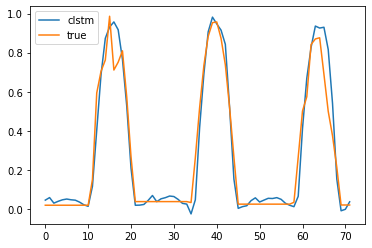

In [39]:
plt.plot(y_hat_clstm[:,0], label='clstm')
plt.plot(y_test_clstm, label='true')
plt.legend()

# MMFF

## Train

In [8]:
from mlopt.MMFFBleding_Regressor import MMFFBleding
X_train_blender, y_train_blender, X_test_blender, y_test_blender = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

MMFF_model = MMFFBleding(X_train_blender, y_train_blender, X_test_blender, y_test_blender, LinearRegression())
MMFF_model.train()
y_hat_blender = MMFF_model.predict(X_test_blender)

print('Resultado Dados Teste!')
print('MMFF')
print('MAE: ', mae(y_hat_blender, y_test_blender))
print('MSE: ', mse(y_hat_blender, y_test_blender))
print('MAPE: ', MAPE(y_hat_blender, y_test_blender))

Train: (288, 23), Test: (72, 23)
Resultado Dados Teste!
MMFF
MAE:  0.044270282506149616
MSE:  0.006897449737608178
MAPE:  0.3205333967203688


In [26]:
pickle.dump(MMFF_model, open('resultados/best_blender_trained.pckl', 'wb'))

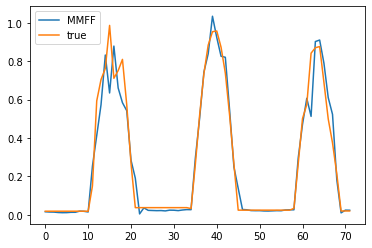

In [27]:
plt.plot(y_hat_blender, label='MMFF')
plt.plot(y_test_blender, label='true')
plt.legend()

## Results

In [28]:
MMFF_model_loaded = pickle.load(open('resultados/best_blender_trained.pckl', 'rb'))

y_hat_blender = MMFF_model_loaded.predict(X_test_blender)

print('Resultado Dados Teste!')
print('MMFF')
print('MAE: ', mae(y_hat_blender, y_test_blender))
print('MSE: ', mse(y_hat_blender, y_test_blender))
print('MAPE: ', mean_absolute_percentage_error(y_hat_blender, y_test_blender))

Resultado Dados Teste!
MMFF
MAE:  0.044270282506149616
MSE:  0.006897449737608178
MAPE:  0.3594156530877767


# Figura Unica

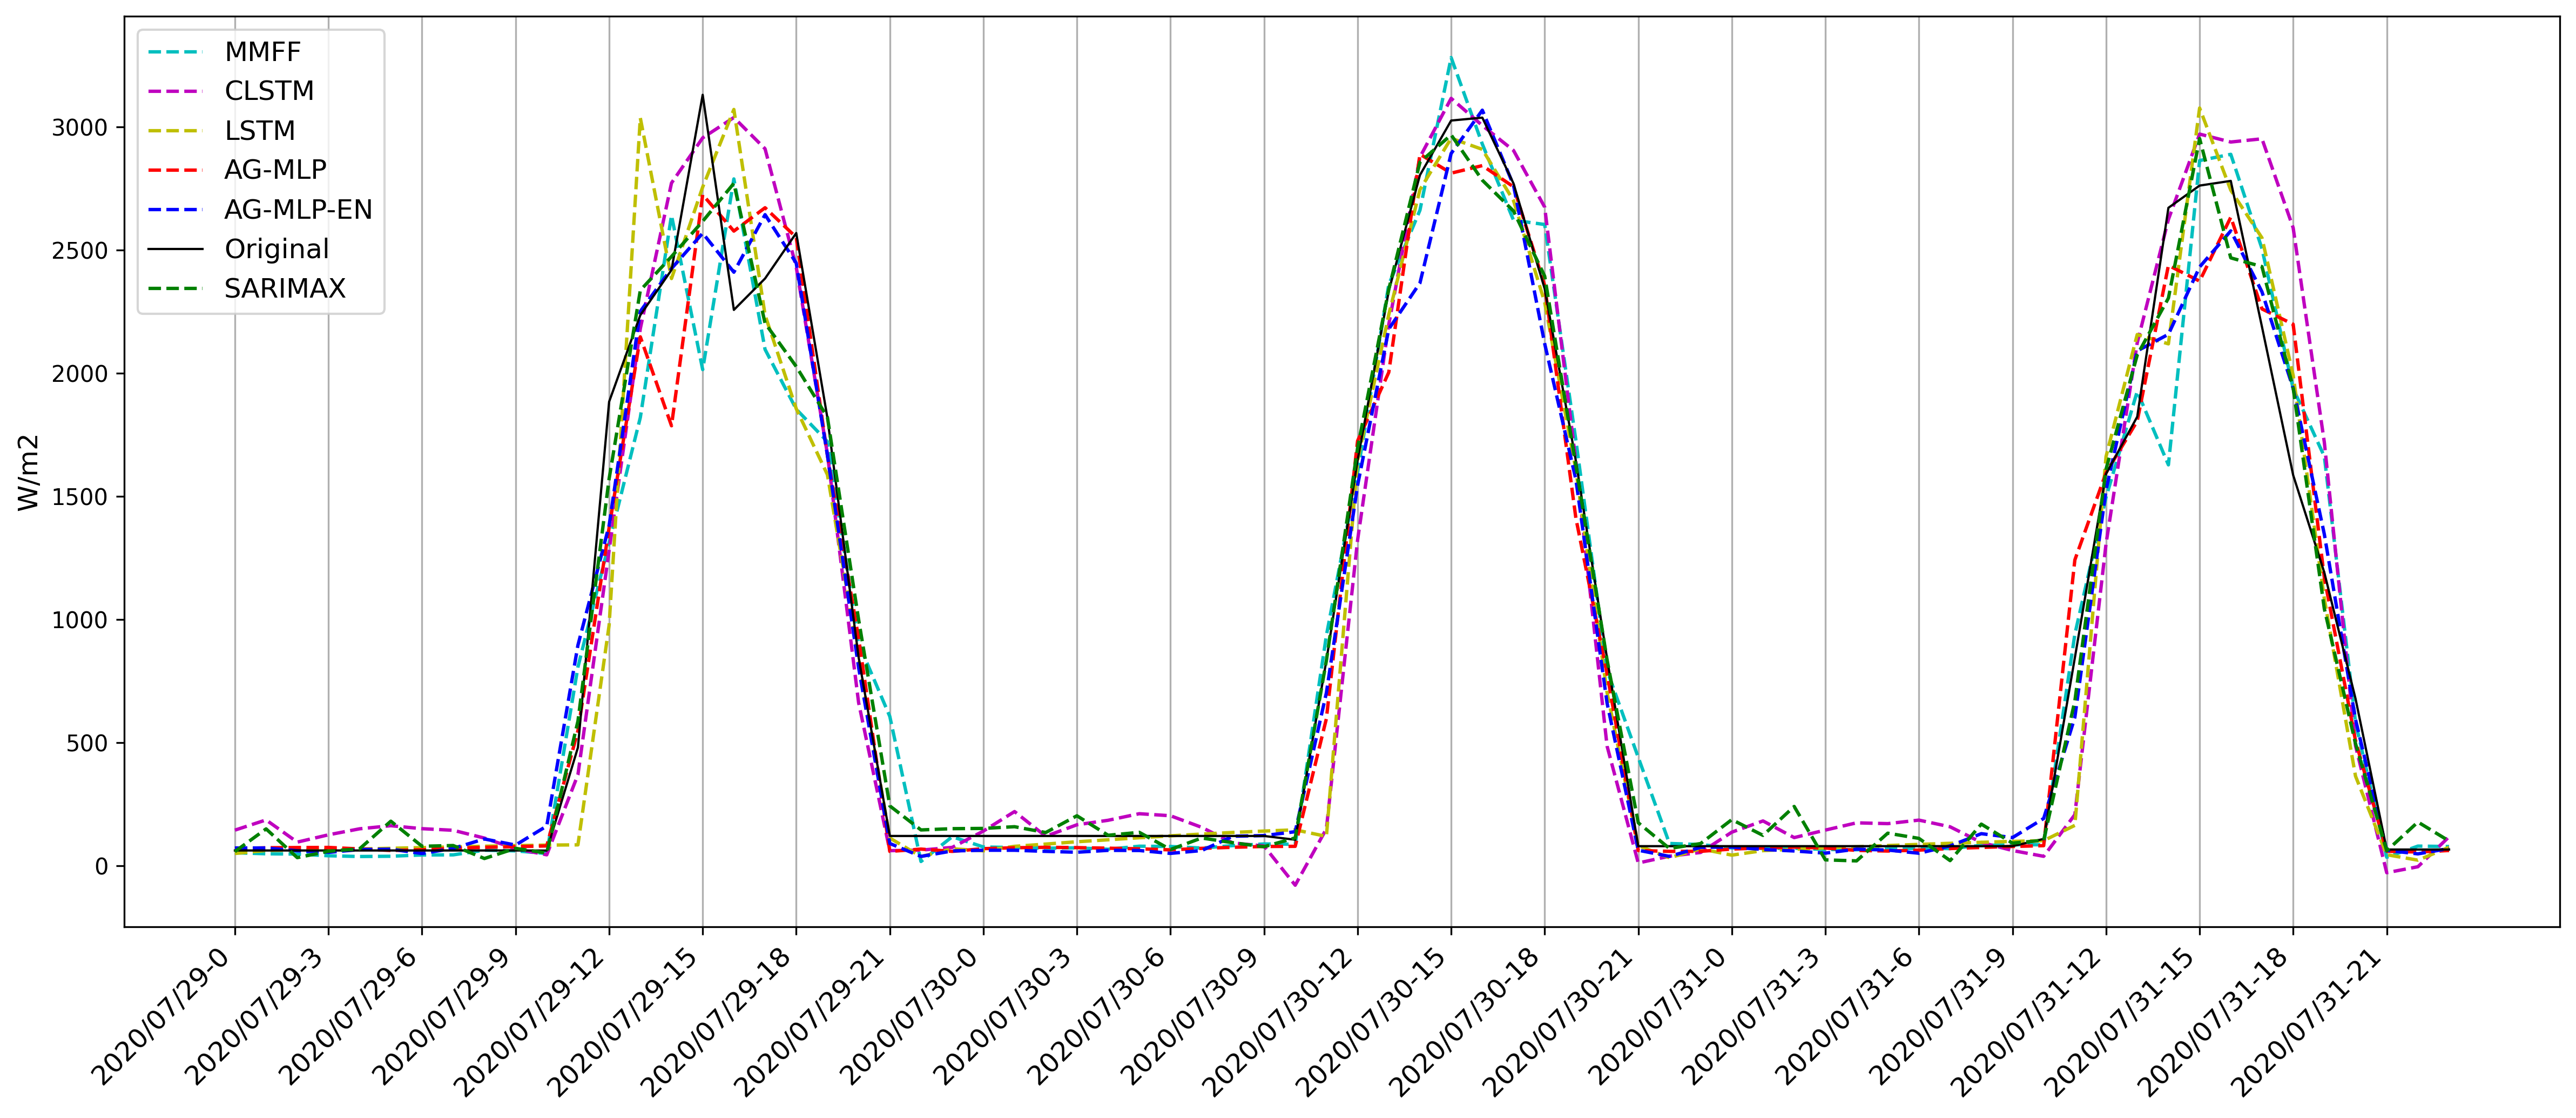

In [40]:
fig, ax = plt.subplots(1,1, figsize=(16,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_blender[-len_dt:].reshape(-1, 1)), 'c--', label='MMFF')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_clstm[-len_dt:].reshape(-1, 1)), 'm--', label='CLSTM')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_lstm[-len_dt:].reshape(-1, 1)), 'y--', label='LSTM')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_residual[-len_dt:].reshape(-1, 1)), 'r--'
        , label='AG-MLP')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_vr_residual[-len_dt:].reshape(-1, 1)),'b--',
        label='AG-MLP-EN')

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'k', label='Original',
       linewidth=1)
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--', label='SARIMAX')

plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/comparison_hibrids_test.png', dpi=300)

# NARNN - ARMAX

## Train

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten
from mlopt.ACOLSTM import ACOLSTM

X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

options_ACO={'antNumber':1, 'antTours':1, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}

lstmOptimizer = ACOLSTM(X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn, n_variables=1,
                        options_ACO=options_ACO, verbose=True)

final_model, y_hat_narnn = lstmOptimizer.optimize(Layers_Qtd = [[40, 50, 60, 70], [20, 25, 30], [5, 10, 15]],
                                                  epochs=[300])

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[40, 50, 60, 70], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [20, 25, 30], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [5, 10, 15], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3], [0]]
Space Created:  [[40  0  0 ...  0  0  0]
 [40  0  0 ...  0  1  0]
 [40  0  0 ...  0  2  0]
 ...
 [70  5  5 ...  5  1  0]
 [70  5  5 ...  5  2  0]
 [70  5  5 ...  5  3  0]]
number of Space Possibilities (rows):  1119744
Setting fitness for
[60  0  3 25  3  3 15  3  1  0]


2021-06-17 22:56:49,755 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


{'fl_qtn': 60, 'fl_func': 'elu', 'fl_refunc': 'relu', 'sl_qtn': 25, 'sl_func': 'relu', 'sl_refunc': 'relu', 'tl_qtn': 15, 'tl_func': 'relu', 'optimizer': 'adam'}


2021-06-17 22:56:49,755: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-06-17 22:56:55,673 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-06-17 22:56:55,673: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Epoch 1/300
9/9 [==============================] - 199s 654ms/step - loss: 0.2077 - mse: 0.1289
Epoch 2/300
9/9 [==============================] - 5s 659ms/step - loss: 0.2060 - mse: 0.1210
Epoch 3/300
9/9 [==============================] - 6s 674ms/step - loss: 0.1964 - mse: 0.1125
Epoch 4/300
9/9 [==============================] - 10s 1s/step - loss: 0.1408 - mse: 0.0596
Epoch 5/300
9/9 [==============================] - 1s 120ms/step - loss: 0.1055 - mse: 0.0325
Epoch 6/300
9/9 [==============================] - 1s 112ms/step - loss: 0.0839 - mse: 0.0215
Epoch 7/300
9/9 [==============================] - 1s 113ms/step - loss: 0.0640 - mse: 0.0123
Epoch 8/300
9/9 [==============================] - 1s 128ms/step - loss: 0.0703 - mse: 0.0122
Epoch 9/300
9/9 [==============================] - 1s 133ms/step - loss: 0.0600 - mse: 0.0094
Epoch 10/300
9/9 [==============================] - 5s 641ms/step - loss: 0.0559 - mse: 0.0089
Epoch 11/300
9/9 [==============================] - 1s 116m

2021-06-17 23:21:08,228 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-06-17 23:21:08,228: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-06-17 23:21:08,342 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-06-17 23:21:08,342: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Epoch 1/300
9/9 [==============================] - 11s 89ms/step - loss: 0.1994 - mse: 0.1200
Epoch 2/300
9/9 [==============================] - 1s 78ms/step - loss: 0.1529 - mse: 0.0626
Epoch 3/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1163 - mse: 0.0347
Epoch 4/300
9/9 [==============================] - 1s 98ms/step - loss: 0.1022 - mse: 0.0262
Epoch 5/300
9/9 [==============================] - 1s 103ms/step - loss: 0.0913 - mse: 0.0212
Epoch 6/300
9/9 [==============================] - 1s 115ms/step - loss: 0.0802 - mse: 0.0162
Epoch 7/300
9/9 [==============================] - 1s 130ms/step - loss: 0.0767 - mse: 0.0137
Epoch 8/300
9/9 [==============================] - 1s 126ms/step - loss: 0.0778 - mse: 0.0138
Epoch 9/300
9/9 [==============================] - 1s 125ms/step - loss: 0.0695 - mse: 0.0119
Epoch 10/300
9/9 [==============================] - 1s 112ms/step - loss: 0.0717 - mse: 0.0115
Epoch 11/300
9/9 [==============================] - 1s 103ms/s

In [ ]:
final_model.save('./resultados/narnn_model')

## Results

In [ ]:
X_total = np.concatenate([X_train_rnn, X_test_rnn])
y_total_narnn = final_model.predict(X_total.reshape((X_total.shape[0], X_total.shape[1], 1)))

pm.auto_arima(y=gen, X=y_total_narnn.reshape(-1, 1), seasonal=False, maxiter=50, trace=True)

mod = SARIMAX(endog=gen, exog=y_total_narnn, order=(1,0,0))
results = mod.fit(disp=True)
y_armax_narnn = results.predict()
mape_autoarima = MAPE(y_sarimax_auto, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as MAPESK

y_armax_narnn_test = y_armax_narnn[-len(y_test_rnn):]

print('Resultado Dados Teste!')
print('MMFF')
print('MAE: ', mae(y_test_rnn, y_armax_narnn_test))
print('MSE: ', mse(y_test_rnn, y_armax_narnn_test))
print('MAPE: ', MAPESK(y_test_rnn, y_armax_narnn_test))

plt.plot(y_armax_narnn_test, label='pred')
plt.plot(y_test_rnn, label='true')
plt.legend()